In [4]:
from glob import glob
import gzip
import contextlib
import json
import re
import zipfile
import tarfile
import tempfile
import os
import pathlib
import subprocess
import notebook_helper
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# depending on which test runner was used, the collection archive may be either a zip (local docker & exec runner),
# or a tar.gz file (k8s). Unfortunately, the zipfile and tarfile modules are different species of waterfowl,
# so we duck typing doesn't help. So this method extracts whichever one we have to a temp directory and
# returns the path to the temp dir.
# use as a context manager, so the temp dir gets deleted when we're done:
#   with open_archive(archive_path) as a:
#     files = glob(a + '/**/tracer-output')
@contextlib.contextmanager
def open_archive(archive_path):
    # zipfile and tarfile both have an extractall method, at least
    #print(archive_path)
    if zipfile.is_zipfile(archive_path):
        z = zipfile.ZipFile(archive_path)
    else:
        z = tarfile.open(archive_path, 'r:gz')

    #print(z)
    with tempfile.TemporaryDirectory(prefix='pubsub-tg-archive-') as d:
        #print(d)
        z.extractall(path=d)
        yield d
   
def concat_files(names, outfile):
    for name in names:
        with open(name, 'rb') as f:
            outfile.write(f.read())

def mkdirp(dirpath):
    pathlib.Path(dirpath).mkdir(parents=True, exist_ok=True)

PEER_INFO_PATTERN = re.compile(
    r'Host peer ID: ([0-9a-zA-Z]+), seq (\d+)')


def extract_peer_info(run_out):
    infos = []
    with open(run_out, 'rt') as f:
        for line in f.readlines():
            m = PEER_INFO_PATTERN.search(line)
            if m:
                pid = m.group(1)
                seq = int(m.group(2))
                node_type = m.group(3)
                node_type_seq = int(m.group(4))
                node_index = int(m.group(5))
                node_index_bound = int(m.group(6))
                infos.append(
                    {'peer_id': pid,
                     'seq': seq})
    if len(infos) == 0:
        print('warning: no peer info found in {}'.format(run_out))
    return infos

def extract_timing_info(run_out, node_type):
    times = dict(t_warm=0, t_connect=0, t_run=0, t_cool=0, t_complete=0)

    with open(run_out, 'rt') as f:
        for line in f.readlines():
            try:
                obj = json.loads(line)
            except BaseException as err:
                print("error parsing run output: ", err)
                continue
            if 'ts' not in obj or 'event' not in obj or obj['event'].get('type', '') != 'message':
                continue
            msg = obj['event']['message']
            ts = obj['ts']
            if re.match(r'connecting to peers.*', msg):
                times['t_connect'] = ts
                continue

            # the rest of the times are only logged by honest peers
            if node_type != 'honest':
                continue
            if re.match(r'Wait for .* warmup time', msg):
                times['t_warm'] = ts
                continue
            if re.match(r'Wait for .* run time', msg):
                times['t_run'] = ts
                continue
            if re.match(r'Run time complete, cooling down.*', msg):
                times['t_cool'] = ts
                continue
            if msg == 'Cool down complete':
                times['t_complete'] = ts
                continue
            
def extract_peer_and_timing_info(run_out_files):
    entries = []
    for filename in run_out_files:
        infos = extract_peer_info(filename)
        #print(infos)
        if infos is None or len(infos) == 0:
            continue

        # FIXME: we only get the timing info for the first peer in the container
        # unfortunately, getting the times for individual peers requires code changes
        times = extract_timing_info(filename, infos[0].get('type', 'unknown'))
        for info in infos:
            info.update(times)
            entries.append(info)
    return entries

# sugar around recursive glob search
def find_files(dirname, filename_glob):
    path = '{}/**/{}'.format(dirname, filename_glob)
    return glob(path, recursive=True)

def aggregate_output(output_zip_path, out_dir):
    topology = dict()

    #print(output_zip_path)
    with open_archive(output_zip_path) as archive:
        #print(archive)
        tracefiles = find_files(archive, 'tracer-output-*')
        names = [f for f in tracefiles if 'full' in f]
        if len(names) > 0:
            with gzip.open(os.path.join(out_dir, 'full-trace.bin.gz'), 'wb') as gz:
                concat_files(names, gz)

        #print(archive)
        # get peer id -> seq mapping & timing info from run.out files
        #names = find_files(archive, 'run.out')
        #info = extract_peer_and_timing_info(names)
        #dest = os.path.join(out_dir, 'peer-info.json')
        #with open(dest, 'wt') as f:
        #    json.dump(info, f)

def extract_test_outputs(test_output_zip_path, output_dir=None):
    if output_dir is None or output_dir == '':
        output_dir = os.path.join(os.path.dirname(test_output_zip_path), 'analysis')

    raw_output_dir = os.path.join(output_dir, 'raw-data')
    mkdirp(raw_output_dir)
    aggregate_output(test_output_zip_path, raw_output_dir)
    run_blockstat_cdf(raw_output_dir)
    #run_tracestat_hops(raw_output_dir)
    #run_tracestat_dups(raw_output_dir)
    run_blockstat_avg(raw_output_dir)

    #if convert_to_pandas:
    print('converting data to pandas format...')
    pandas_dir = os.path.join(output_dir, 'pandas')

    notebook_helper.cdf_to_panda(raw_output_dir, pandas_dir)
    notebook_helper.hops_to_panda(raw_output_dir, pandas_dir)
    notebook_helper.dups_to_panda(raw_output_dir, pandas_dir)
    notebook_helper.avg_to_panda(raw_output_dir, pandas_dir)

    #if prep_notebook:
    #    prepare_analysis_notebook(analysis_dir=output_dir)
    return output_dir

def run_blockstat_cdf(tracer_output_dir):
    full = os.path.join(tracer_output_dir, 'full-trace.bin.gz')
    if os.path.exists(full):
        tracer_output = full
    else:
        print('no event tracer output found, skipping tracestat')
        return

    print('running blockstat on {}'.format(tracer_output))
    try:
        cmd = ['blockstat', '-cdf', tracer_output]
        p = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except BaseException as err:
        print('error calling tracestat: ', err)
        return

    # split output into summary and latency CDF
    [summary, cdf] = p.stdout.split('=== Propagation Delay CDF (ms) ===')

    with open(os.path.join(tracer_output_dir, 'tracestat-summary.txt'), 'w', encoding='utf8') as f:
        f.write(summary)
    with open(os.path.join(tracer_output_dir, 'tracestat-cdf.txt'), 'w', encoding='utf8') as f:
        f.write(cdf)

def run_blockstat_avg(tracer_output_dir):
    full = os.path.join(tracer_output_dir, 'full-trace.bin.gz')
    if os.path.exists(full):
        tracer_output = full
    else:
        print('no event tracer output found, skipping tracestat')
        return

    print('running blockstat on {}'.format(tracer_output))
    try:
        cmd = ['blockstat', '-avg', tracer_output]
        p = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except BaseException as err:
        print('error calling blockstat: ', err)
        return

    # split output into summary and latency CDF
    [summary, cdf] = p.stdout.split('=== Average Delay (ms) ===')

    with open(os.path.join(tracer_output_dir, 'tracestat-avg.txt'), 'w', encoding='utf8') as f:
        f.write(cdf)
    #print(cdf)
    

cwd = os.getcwd()

op_avg_nodes={}
op_df_nodes={}
op_avg_batch={}
op_df_batch={}

#ops_path_size = {'100KB': cwd+'/cli69balo7j5ldtg5btg',
#         '200KB': cwd+'/clf2o6qlo7j3qk8pnt9g',
#         '300KB': cwd+'/clf2o9ilo7j3qk8pnta0'}
ops_path_batch = {}
#ops_path_batch ={'Batch+Gossip':'',
#                'Only Gossip':'',
#                'Only Batch':''}
ops_path_nodes = {#'2 nodes': cwd+'/cli69bqlo7j5ldtg5bu0',
         '10 nodes': cwd+'/cm08cvalo7jaljv7ieig',
          '50 nodes': cwd+'/cm08g7alo7jaljv7iej0'
 }
#ops_path_dis ={'Seq down':'',
#                'Full node down':''}
#ops_path_quic = {'quic': cwd+'/clfiiailo7j5rfvupp20',
#                 'tcp': cwd+'/clfif7ilo7j5rfvupp1g'}
ops_path_quic = {}

for key in ops_path_batch:
    print(key,ops_path_batch[key])
    extract_test_outputs(ops_path_batch[key]+'.tgz',ops_path_batch[key])
    op_df_batch[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/cdf.csv',index_col=False,low_memory=False)
    op_avg_batch[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/avg.csv',index_col=False,low_memory=False)

for key in ops_path_nodes:
    print(key,ops_path_nodes[key])
    extract_test_outputs(ops_path_nodes[key]+'.tgz',ops_path_nodes[key])
    op_df_nodes[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/cdf.csv',index_col=False,low_memory=False)
    #op_hops_nodes[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/hops.csv',index_col=False,low_memory=False)
    #op_dups_nodes[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/dups.csv',index_col=False,low_memory=False)
    op_avg_nodes[key] = pd.read_csv(ops_path_nodes[key]+'/pandas/avg.csv',index_col=False,low_memory=False)

#for key in ops_path_quic:
#    extract_test_outputs(ops_path_quic[key]+'.tgz',ops_path_quic[key])
#    op_df_quic[key] = pd.read_csv(ops_path_quic[key]+'/pandas/cdf.csv',index_col=False,low_memory=False)


10 nodes /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig
running blockstat on /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/raw-data/full-trace.bin.gz
running blockstat on /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/raw-data/full-trace.bin.gz
converting data to pandas format...
converting latency cdf to pandas...
writing cdf pandas data to /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/pandas/cdf.csv
converting number of hops to pandas...
writing cdf pandas data to /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/pandas/hops.csv
converting latency cdf to pandas...
writing cdf pandas data to /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/pandas/dups.csv
converting average latency  to pandas...
writing cdf pandas data to /home/sergi/workspace/dymension/dymint_testplan/cm08cvalo7jaljv7ieig/pandas/avg.csv


NameError: name 'op_df_size' is not defined

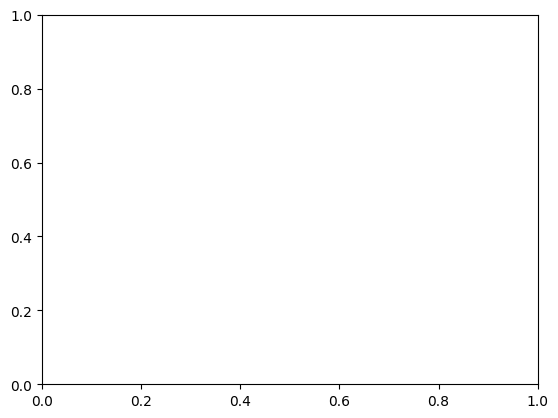

In [5]:
fig, ax = plt.subplots()


for key in op_df_size:

    #df = op_df_size[key].loc[(op_df_size[key]['count'] > 100)]
    #print(df)
    df = op_df_size[key]
    df_values = df['delay_ms']
    df_count = df['count']/(df['count'].max())
    ax.plot(df_values,df_count,label=key)
#ax3.set_xlim([0,200])
ax.legend()
ax.set_ylim([0,1])

ax.set_title("CDF Block propagation time from sequencer to nodes)")
ax.set_xlabel("Propagation time (ms)")


Text(0.5, 0, 'Propagation time (ms)')

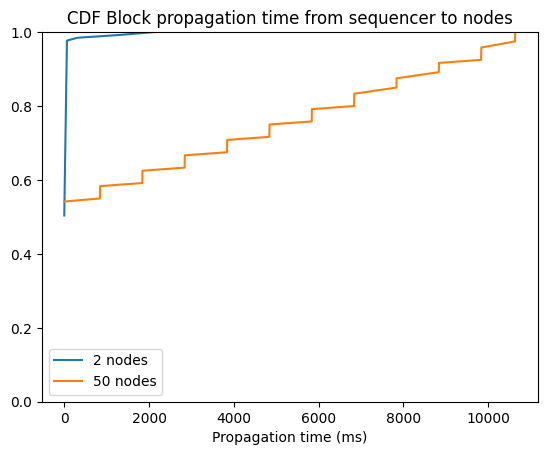

In [ ]:
fig, ax = plt.subplots()


for key in op_df_nodes:

    #df = op_df_size[key].loc[(op_df_size[key]['count'] > 100)]
    #print(df)
    df = op_df_nodes[key]
    df_values = df['delay_ms']
    df_count = df['count']/(df['count'].max())
    ax.plot(df_values,df_count,label=key)
#ax3.set_xlim([0,200])
ax.legend()
ax.set_ylim([0,1])

ax.set_title("CDF Block propagation time from sequencer to nodes")
ax.set_xlabel("Propagation time (ms)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Propagation time (ms)')

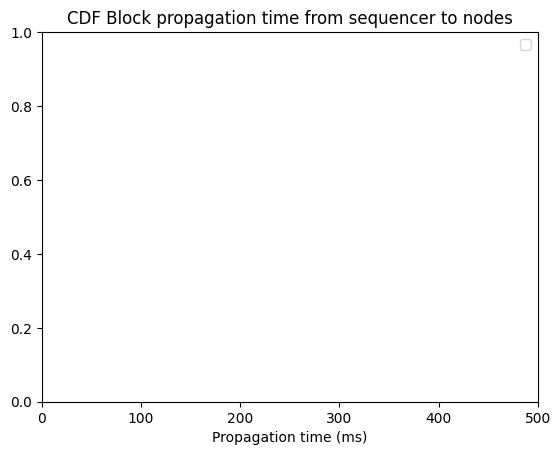

In [ ]:
fig, ax = plt.subplots()


for key in op_df_quic:

    #df = op_df_size[key].loc[(op_df_size[key]['count'] > 100)]
    #print(df)
    df = op_df_quic[key]
    df_values = df['delay_ms']
    df_count = df['count']/(df['count'].max())
    ax.plot(df_values,df_count,label=key)
ax.set_xlim([0,500])
ax.legend()
ax.set_ylim([0,1])

ax.set_title("CDF Block propagation time from sequencer to nodes")
ax.set_xlabel("Propagation time (ms)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '# hops')

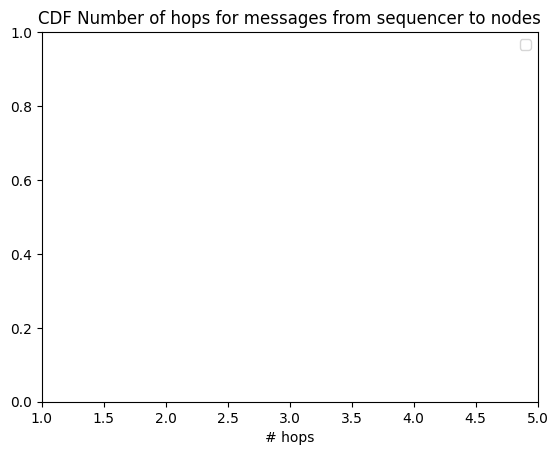

In [ ]:
fig, ax = plt.subplots()

for key in op_hops_nodes:

    #df = op_df_size[key].loc[(op_df_size[key]['count'] > 100)]
    df = op_hops_nodes[key]
    print(df)
    df_values = df['delay_ms']
    df_count = df['count']/(df['count'].max())
    ax.plot(df_values,df_count,label=key)
ax.set_xlim([1,5])
ax.legend()
ax.set_ylim([0,1])

ax.set_title("CDF Number of hops for messages from sequencer to nodes")
ax.set_xlabel("# hops")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '# duplicates received')

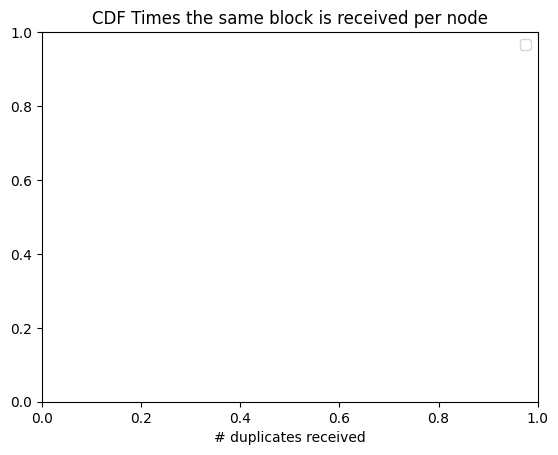

In [ ]:
fig, ax = plt.subplots()

for key in op_dups_nodes:

    df = op_dups_nodes[key]
    df_values = df['delay_ms']
    df_count = df['count']/(df['count'].max())
    ax.plot(df_values,df_count,label=key)
#ax.set_xlim([1,5])
ax.legend()
ax.set_ylim([0,1])

ax.set_title("CDF Times the same block is received per node")
ax.set_xlabel("# duplicates received")

0      3255
1      3062
2      2873
3      2681
4      2488
       ... 
299      55
300      56
301      56
302      55
303      56
Name: delay_ms, Length: 304, dtype: int64


Text(0, 0.5, 'Propagation time (ms)')

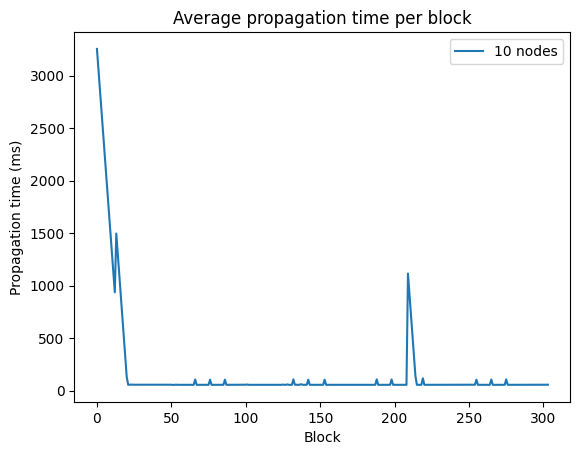

In [7]:
fig, ax = plt.subplots()

for key in op_avg_nodes:

    df = op_avg_nodes[key]
    print(df['delay_ms'])
    ax.plot(df['delay_ms'],label=key)
   # ax.plot(df_values,df_count,label=key)

#ax.set_xlim([0,25])
ax.legend()
#ax.set_ylim([0,1000])

ax.set_title("Average propagation time per block")
ax.set_xlabel("Block")
ax.set_ylabel("Propagation time (ms)")